https://watermark.silverchair.com/tacl_a_00008.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAqkwggKlBgkqhkiG9w0BBwagggKWMIICkgIBADCCAosGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMdPHYXwG3pcrWAWblAgEQgIICXLAPHfS6DARCCcJOQgNOoHW0d6UCjs3oxS-PWDFPOk7X9faJxJOnQ5Uw6pVYoyKusEjj9WPNYLS9lXu3It3oT9_evEDplawruHZ6wGGCRQaE2lL6UnFonGuX2VA_B78COLDzUNsLq7H8HJxYcnM69qXSXtecSG0BgIxzl5GDuJjEnmw7s0l-fCwtKeu31OCom2mdkQZVvow05n1a1POX4yb_IHr0BfUu2_jpJJdhXp7CT8PuH0NFUwgf9R6nEnQxV0iMnb-31-MrLir4VL1KpJGYvTWhGRYGWgW76E5iSGpIShl47bzyPQcmzwrtv1H5JtOCQ38Xom6pQLb8gX5xlPTnEHxykR2yV_eDu9WlUkty_AHo-CIipkLzW18YDmVAopNNJtBDM6PwA0AzEdhzTk3hM2L2rsevblwlZMyGvpuvxnentatFdU5P8NI7beqdveY8ff0TID8C1lB5u3ZmeYPmcAytAdVt9yyD3iMCRO8CUntiIxJaX6QO0QzI9KPlW3-3RM4WqRq-ZCA3sb9jsLuaftRhEebIGEh_O5zH_H4r6K--NZWNXsEtrbTKWhgTuTTCaUfRIab88OV0MvyBj6S59SwcjSfJnJjOLVXG0d8LqRNuld2eDe-mBUm1PoeLEFrrCfNArKe-GyXejS68fN4bxzKF3vcJWnG054eJG95zvDY0xQeyvPGp0EVqh26f7sQ3O21AHBnqKTL9IvIhHZk3Ytvl9R_-_q26JdmVX-Qve7vU1T5XEHofsvq48CUgG4kNo8CX4cuuM64tEGOCtB6p41tvLhT_TQdFKso

In [1]:
!pwd

/home/dritsakon/repos/paper_greekparliament/src


In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import random as rn
import datetime
import re
import os
tqdm.pandas()
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq
import itertools
# import tensorflow as tf

In [3]:
#make results reproducible

# initial seeds
%env PYTHONHASHSEED=13
np.random.seed(13)
rn.seed(12345)
my_seed = 12345


env: PYTHONHASHSEED=13


In [4]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]

(1280918, 12)
(1274505, 12)


'παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος'

In [5]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [6]:
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df.speech.head(4)

0    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...
1    παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...
2    κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...
3                                              @sw @sw
Name: speech, dtype: object

In [7]:
#New column year
df['year'] = df['sitting_date'].dt.year
df['decade'] = (df['year']//10)*10
df = df[df.decade != 1980] # remove dates before 2000 to catch the three last decades
df = df[df.decade != 2020]# remove dates after 2019 to catch the three last decades
df = df[df.decade != 2000]# remove dates after 2019 to catch the three last decades

df.speech = df.speech.progress_apply(lambda x: x.replace(".", " . ")) #add space around dot

print(set(df.decade.to_list()))

100%|██████████| 860546/860546 [00:05<00:00, 171816.15it/s]


{2010, 1990}


In [8]:
df.columns

Index(['member_name', 'sitting_date', 'parliamentary_period',
       'parliamentary_session', 'parliamentary_sitting', 'political_party',
       'government', 'member_region', 'roles', 'member_gender', 'speaker_info',
       'speech', 'year', 'decade'],
      dtype='object')

In [9]:
df.speech = df.speech+' . '

In [10]:
print(df.speech.iloc[1])

κυριοι συναδελφοι @sw προχωρησουμε @sw ορκωμοσια @sw συναδελφου βασιλη κοραχαη . παρακαλειται @sw βασιλης κοραχαης @sw προσελθει @sw @sw ορκισθει . ορκιζομαι @sw ονομα @sw αγιας @sw ομοουσιας @sw αδιαιρετης τριαδας @sw @sw πιστος @sw πατριδα @sw @sw δημοκρατικο πολιτευμα @sw υπακουω @sw συνταγμα @sw @sw νομους @sw @sw εκπληρω ευσυνειδητα @sw καθηκοντα @sw . 


In [11]:
#concat sentences, each last sentence for each speech did not have dot so add one.
print('Preparing data...')
df.speech = df.speech.progress_apply(lambda x: x.replace('\n', ' '))
df.speech = df.speech.progress_apply(lambda x: re.sub('\s\s+' , ' ', x)) 
df.speech = df.speech.progress_apply(lambda x: x.replace('. ', '.\n'))
 
print('Group by decades...')
print(datetime.datetime.now())
PERdecade_df = df.groupby(df.decade)['speech'].progress_apply(''.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.


  5%|▍         | 39010/860546 [00:00<00:02, 390094.79it/s]

Preparing data...


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]

Group by decades...
2021-04-17 01:54:04.326680


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


In [12]:
# PERdecade_df.speech[0] = PERdecade_df.speech[0][:100000]
# PERdecade_df.speech[1] = PERdecade_df.speech[1][:100000]
# print(len(PERdecade_df.speech.iloc[0]))
# print(len(PERdecade_df.speech.iloc[1]))
# print(PERdecade_df.head())

In [13]:
shifts_PERdecade_list=[]

for i in range(2):
    print('********************************************************')
    print('Repeat No ', str(i))
#     print('Shuffling...')
#     df = df.sample(frac=1).reset_index(drop=True)
    
    if i==0:
        %env PYTHONHASHSEED=13
        np.random.seed(13)
        rn.seed(12345)
        my_seed = 12345
#         tf.random.seed(my_seed)
#         Word2Vec.random = np.random.RandomState(my_seed)
#         Word2Vec.seed = my_seed
    else:
        %env PYTHONHASHSEED=64
        np.random.seed(64)
        rn.seed(54321)
        my_seed=54321
#         tf.random.seed(my_seed)
#         Word2Vec.random = np.random.RandomState(my_seed)
#         Word2Vec.seed = my_seed
    
    print(datetime.datetime.now())
    
    print('Creating training texts...')
    training_texts_dir = 'training_texts/compass_stability/'
    if not os.path.exists(training_texts_dir):
        os.makedirs(training_texts_dir)

    for decade, speech in tqdm(zip(PERdecade_df.decade, PERdecade_df.speech)):
    #     print(year)
        with open(training_texts_dir+str(decade)+'_'+str(i)+'.txt', "w", encoding='utf-8') as o:
            o.write(speech)  
            
    #sort dataframe by year
    PERdecade_df.sort_values(by='decade')
    decades = sorted(PERdecade_df.decade.to_list())
#     decade_pairs = list(itertools.combinations(decades, 2))
    decade_pairs = step_one_pairs(decades)
#     print(decade_pairs)

    print('Training aligned models...')
    print(datetime.datetime.now())

    for pair in tqdm(decade_pairs):
        decade_1, decade_2 = str(pair[0]),str(pair[1])
        print(pair)
        compass_file_path = training_texts_dir+str(decade_1)+'.'+str(decade_2)+'.txt'
        with open(compass_file_path, "w", encoding='utf-8') as o:
            o.write(open(training_texts_dir+decade_1+'_'+str(i)+'.txt', 
                         encoding='utf-8').read()+"\n"+open(training_texts_dir+decade_2+'_'+str(i)+'.txt', 
                                                            encoding='utf-8').read())

        aligner = CADE(size=100, siter=10, diter=1, workers=1)
        aligner.train_compass(compass_file_path, overwrite=True, save=True, seed=my_seed)
#         print('HEEEREEEEEEEEEEE ', aligner.compass.wv.most_similar(positive=['λεει'], topn=1))
        m1 = aligner.train_slice(training_texts_dir+decade_1+'_'+str(i)+'.txt', save=True, seed = my_seed)
#         print('HEEEREEEEEEEEEEE ', m1.wv.most_similar(positive=['λεει'], topn=1))
        m2 = aligner.train_slice(training_texts_dir+decade_2+'_'+str(i)+'.txt', save=True, seed = my_seed)
#         print('HEEEREEEEEEEEEEE ', m2.wv.most_similar(positive=['λεει'], topn=1))

        common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
        print(len(common_vocab))

        for word in common_vocab:

            cos_sim = compute_cosine_similarity(m1, m2, word)
            most_similar_words_period0 = m1.wv.most_similar(positive=[word], topn=10)
            most_similar_words_period1 = m2.wv.most_similar(positive=[word], topn=10)
            shifts_PERdecade_list.append([i, pair, word, cos_sim, len(common_vocab), most_similar_words_period0, most_similar_words_period1])

    print(datetime.datetime.now())


0it [00:00, ?it/s]

********************************************************
Repeat No  0
env: PYTHONHASHSEED=13
2021-04-17 01:54:06.114688
Creating training texts...


2it [00:06,  3.06s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Training aligned models...
2021-04-17 01:54:12.234737
(1990, 2010)
Training the compass from scratch.
Training embeddings: slice training_texts/compass_stability/1990_0.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/compass_stability/2010_0.txt.
Initializing embeddings from compass.
129286


100%|██████████| 1/1 [1:16:38<00:00, 4598.81s/it]
0it [00:00, ?it/s]

2021-04-17 03:10:51.048034
********************************************************
Repeat No  1
env: PYTHONHASHSEED=64
2021-04-17 03:10:51.048604
Creating training texts...


2it [00:05,  2.51s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Training aligned models...
2021-04-17 03:10:56.070160
(1990, 2010)
Training the compass from scratch.
Current saved compass will be overwritten after training
Training embeddings: slice training_texts/compass_stability/1990_1.txt.
Initializing embeddings from compass.
Training embeddings: slice training_texts/compass_stability/2010_1.txt.
Initializing embeddings from compass.
129286


100%|██████████| 1/1 [1:16:23<00:00, 4583.51s/it]

2021-04-17 04:27:19.586809


In [14]:
# ('βουλης', 0.9998518824577332), ('ρουμανια', 0.9990743398666382), ('αιθουσα', 0.9932613372802734)
# ('υπουργου', 0.999855637550354), ('γεγονος', 0.9989751577377319), ('λαρισα', 0.9993413686752319)

# ('προεδρος', 0.9998616576194763), ('ρουμανια', 0.9991392493247986), ('χωρας', 0.9932987093925476)
# ('συνολο', 0.9998013377189636), ('πραγματι', 0.9991621971130371), ('εργου', 0.9992325305938721)

# ('ωρα', 0.9998537302017212), ('παιδειας', 0.9991070032119751), ('χωρας', 0.9932435154914856)
# ('φραγμα', 0.9998247027397156), ('οικονομικων', 0.9991264343261719), ('εργου', 0.9994708299636841)

# ('ελληνικου', 0.9998337030410767), ('ρουμανια', 0.99903404712677), ('χωρας', 0.9928868412971497)
# ('ρουμανιας', 0.9998385906219482), ('ρουμανιας', 0.9991183876991272), ('συζητηση', 0.9994038343429565)

In [15]:
shifts_PERdecade_df = pd.DataFrame(shifts_PERdecade_list, columns = ['iteration', 'decade_pair', 'word', 
                                                                 'semantic_similarity', 'common_voc_size',
                                                                    'top10neighbors_1st_decade',
                                                                    'top10neighbors_2nd_decade'])
print(shifts_PERdecade_df.head())

   iteration   decade_pair          word  semantic_similarity  \
0          0  (1990, 2010)      εποµενως             0.891331   
1          0  (1990, 2010)  παγιδευοντας             0.763374   
2          0  (1990, 2010)     ασυμφορης             0.392838   
3          0  (1990, 2010)   πρωτοκλητος             0.033576   
4          0  (1990, 2010)      λειπουμε             0.687384   

   common_voc_size                          top10neighbors_1st_decade  \
0           129286  [(∆ιοτι, 0.9818968772888184), (πραγµα, 0.97993...   
1           129286  [(πρωτογονος, 0.9299833178520203), (αψυχων, 0....   
2           129286  [(τσαρος, 0.6697994470596313), (αναθερμανσης, ...   
3           129286  [(ζαιμης, 0.6797860860824585), (μετατραπηκατε,...   
4           129286  [(μεταπεισουμε, 0.815516471862793), (ελεγχαμε,...   

                           top10neighbors_2nd_decade  
0  [(εξουσιοδοτουμενος, 0.9174131155014038), (καπ...  
1  [(εξαγνιστουν, 0.8577617406845093), (φοιτητας,...  
2  [(

In [16]:
set(shifts_PERdecade_df.iteration.to_list())

{0, 1}

In [17]:
jjj = shifts_PERdecade_df.word[0]
print(jjj)

εποµενως


In [18]:
# 0 	(1990, 2010) 	λεει 	0.971912 	
# 1 	(1990, 2010) 	λεει 	0.979842

# 0 	(1990, 2010) 	λεει 	0.971713 	
# 1 	(1990, 2010) 	λεει 	0.979326

# λεει 	0.983274 	
# λεει 	0.998995 	

In [19]:
# shifts_PERdecade_df.loc[(shifts_PERdecade_df.word=='λεει')]

In [20]:
print(shifts_PERdecade_df.describe())

shifts_PERdecade_df = shifts_PERdecade_df.sort_values('semantic_similarity')

print('Words with the lowest cosine similarity / highest change')
print(shifts_PERdecade_df.head(20))

print('Words with the highest cosine similarity / lowest change')
print(shifts_PERdecade_df.tail(20))
shifts_PERdecade_df.to_csv('../out_files/stability_compass_2_iterations_dif_seeds_1_worker.csv', index=False)

           iteration  semantic_similarity  common_voc_size
count  258572.000000        258572.000000         258572.0
mean        0.500000             0.655281         129286.0
std         0.500001             0.235612              0.0
min         0.000000            -0.922262         129286.0
25%         0.000000             0.572699         129286.0
50%         0.500000             0.703737         129286.0
75%         1.000000             0.810857         129286.0
max         1.000000             0.994273         129286.0
Words with the lowest cosine similarity / highest change
        iteration   decade_pair              word  semantic_similarity  \
74714           0  (1990, 2010)         διαπραττω            -0.922262   
204000          1  (1990, 2010)         διαπραττω            -0.907862   
191793          1  (1990, 2010)              2513            -0.898337   
187505          1  (1990, 2010)             κομης            -0.893350   
220320          1  (1990, 2010)           

[10, 20, 50, 100, 200, 500, 1000] [0.1, 0.05, 0.06, 0.05, 0.085, 0.092, 0.132]


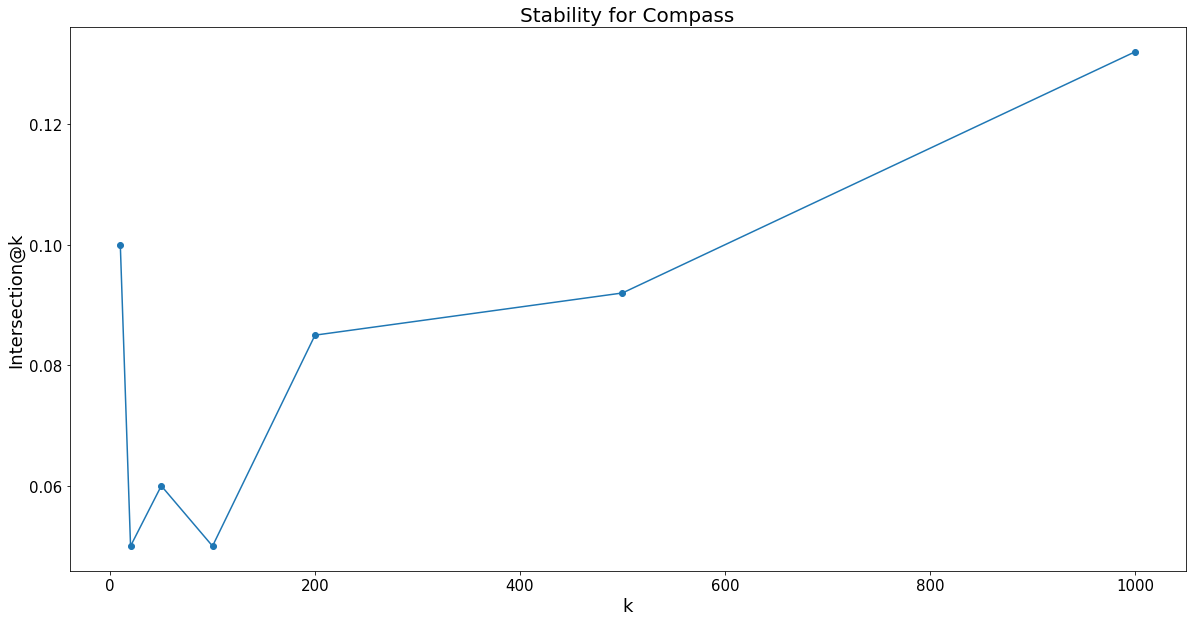

In [21]:
import matplotlib.pyplot as plt

topn_dict = {}
X = []
Y = []

k=[10,20,50,100,200,500,1000]

for n in k:
    
    for iteration in range(2):
        subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
#         print(subdf.shape)
    #     print(subdf.columns)
        subdf.sort_values('semantic_similarity', ascending=False).reset_index(drop=True)
    #     print(subdf.head(2))
        topn_dict[iteration] = subdf.head(n).word.to_list()

    intersection = len(set(topn_dict[0]).intersection(set(topn_dict[1])))
    
    Y.append(intersection/n)
    X.append(n)
    
print(X,Y)

fig = plt.figure(figsize=(15, 8))

fig.set_size_inches(20, 10)
plt.scatter(X,Y)
plt.plot(X,Y)
plt.gca().tick_params(axis='both', which='major', labelsize=15)

plt.xlabel('k', fontsize=18)
plt.ylabel('Intersection@k', fontsize=18)
plt.title('Stability for Compass', fontsize=20)

plt.savefig('../out_files/stability_compass.png', dpi=200,  bbox_inches='tight')
